# Computer Vision : Analyse des armes à feu
Cécile Gontier et Simon Cohen

Notre projet porte sur les armes à feu, et leur détection sur des images à des vidéos en temps réel. Pour cela nous avons utilisé plusieurs techniques de vision par ordinateur en première analyse et peut être essayer de faire de la détection sur image ainsi.

## Données
Comme données, nous avons pu utilser une pistolet en plastique et les prendre en photo dans différentes positions.



(3120, 4160, 3)


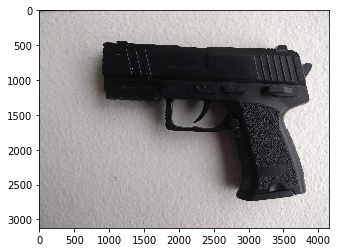

(3091, 3099, 3)


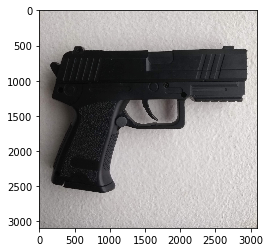

(2477, 2901, 3)


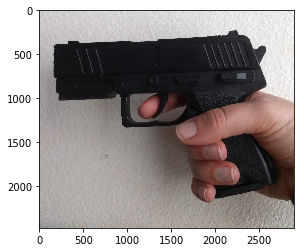

(3115, 3056, 3)


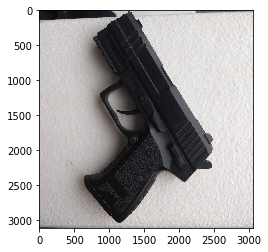

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2

def loadImagebis(src):
    img=cv2.imread(src,1)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,interpolation='nearest')
    plt.show()
    
def loadImage(path, gray=False):
    # TO COMPLETE
    img=cv2.imread(path,1)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if gray:
        plt.imshow(grey,interpolation='nearest', cmap = plt.cm.gray)
        print(grey.shape)
        plt.show()
        return grey
    else :
        plt.imshow(rgb,interpolation='nearest', cmap = plt.cm.gray)
        print(rgb.shape)
        plt.show()
        return rgb

ref = loadImage('./data/gun1.jpg')
miroir = loadImage('./data/gun3.jpg')
occlusion = loadImage('./data/gun6.jpg')
rotation = loadImage('./data/gun7.jpg')

## Première analyse
Nous calculons l'histogramme, faisons un premier seuillage.

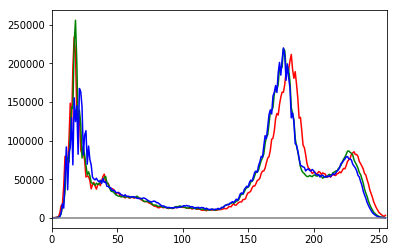

In [8]:
def calculhisto(I, grayI=None):
    color = ('r','g','b')
    for i,col in enumerate(color):
        histr = cv2.calcHist([I],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    grayhist = cv2.calcHist([grayI],[0],None,[256],[0,256])
    plt.plot(grayhist,color = 'gray')
    plt.xlim([0,256])
    plt.show()
    
calculhisto(ref)

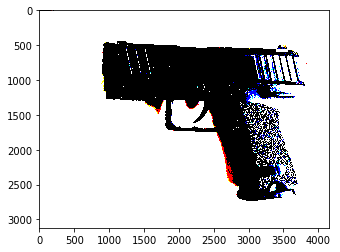

In [9]:
def seuillage(I,s):
    ret, thres = cv2.threshold(I, s, 255, cv2.THRESH_BINARY)
    plt.imshow(thres,interpolation='nearest', cmap = plt.cm.gray)
    plt.show()
    return thres

thres = seuillage(ref, 50)

## Points caractéristiques : SURF
Pour essayer de détecter une arme sur une image, nous avons pensé à utiliser les techniques de feature matching vues en cours. Ici nous utilisons SURF.

Pour être certains d'avoir la bonne version d'opencv (les suivantes ne permettant plus d'utiliser SURF), 
run `pip uninstall opencv-contrib-python`
puis ` pip install opencv-contrib-python==3.4.2.16`.

Nous voyons que SURF détecte très bien les angles, les contours externes mais aussi les particularités à l’intérieur de l’objet (par exemple les reliefs sur la crosse et le canon).

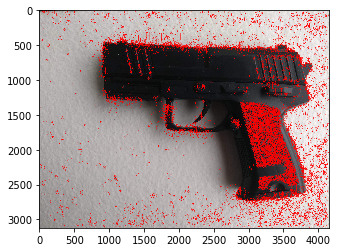

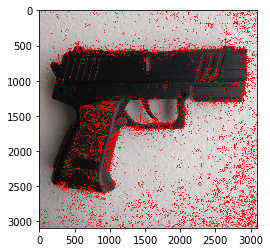

In [7]:
import cv2
import matplotlib.pyplot as plt

def surf(image, threshold=300):
    
    surf = cv2.xfeatures2d.SURF_create(threshold)
    surf.setUpright(True)

    kp_train, des_train = surf.detectAndCompute(image, None)

    train_with_kp = cv2.drawKeypoints(image, kp_train, None, (255, 0, 0), 4)

    plt.imshow(train_with_kp)
    plt.show()

    
surf(ref, 200)
surf(miroir, 200)

## Feature Matching
Si on fait calculer les points caractéritiques sur deux images, on peut récupérer les descriptions de ces points, et un matcher peut comparer et faire correspondre ces points. Nous avons choisi de comparer des images identiques pur vérifier que le matcher marche bien, puis des images similaires : le pistolet en miroir, en rotation et avec occlusion.

Nous avons comparé deux matcheurs différents, pour comparer les résultats.

### BFMatcher

En premier nous utilisons BFMatcher avec la norme L2. Très simplement, pour chaque point de la première image, il va chercher le plus proches voisins parmi les points de la deuxième image, en utilisant la norme donnée sur les descripteurs de points.

Les résultats sont plutôt bons pour le miroir, mais beaucoup moins pour l'occlusion et la rotation. Les algorithmes utilisés sont pourtant censés être résistants à la rotation et l'occlusion, mais icic on voit que ce n'est pas le cas.




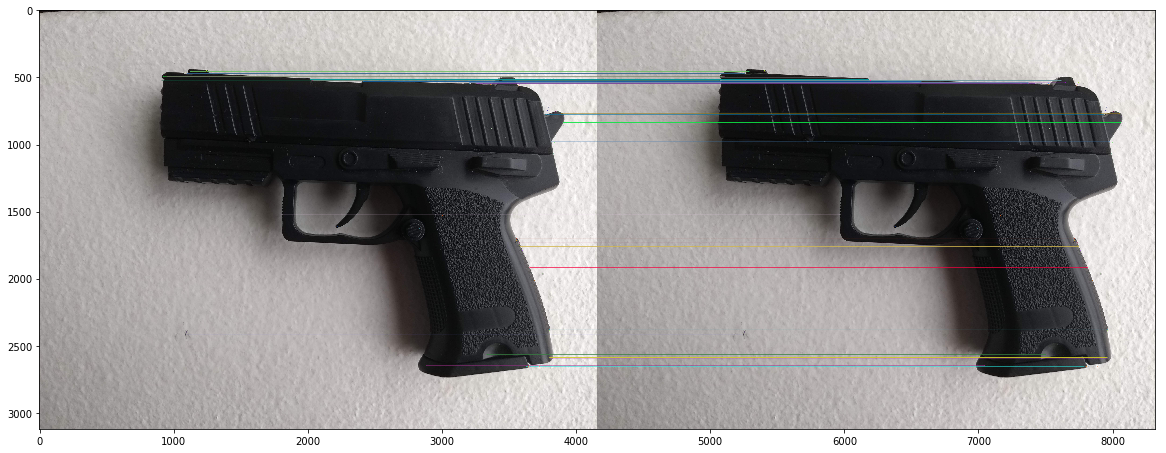

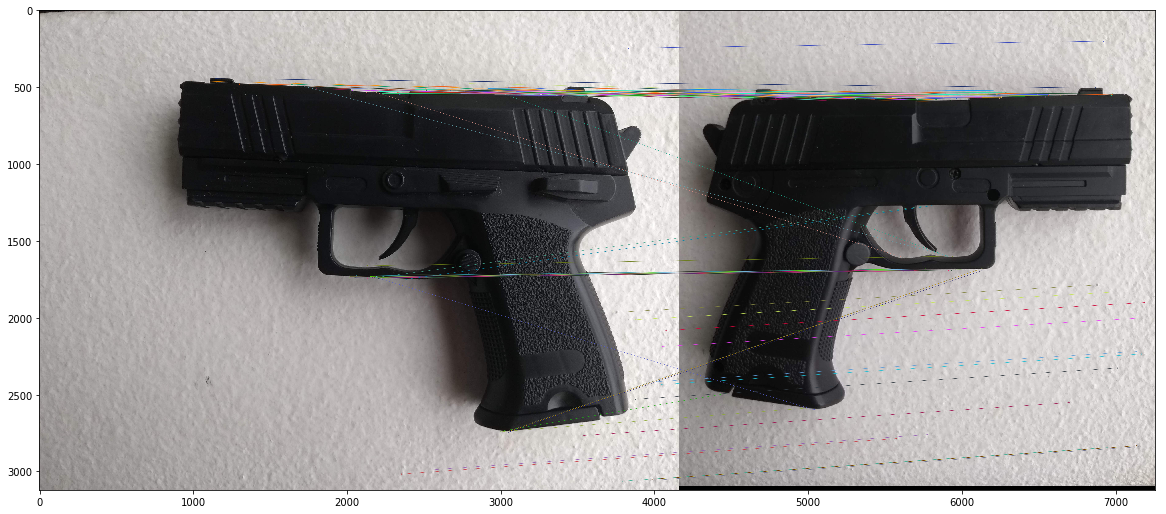

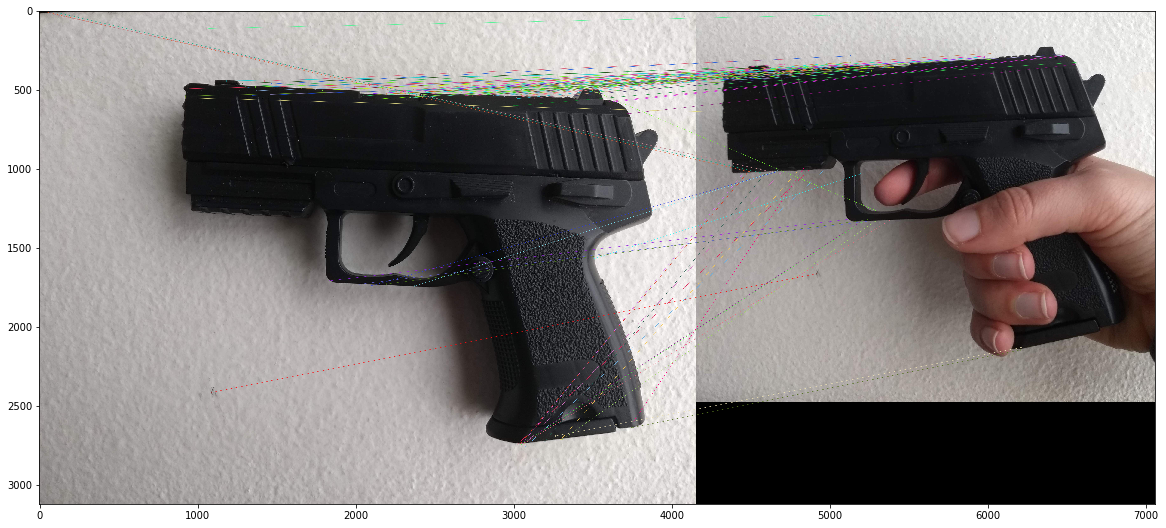

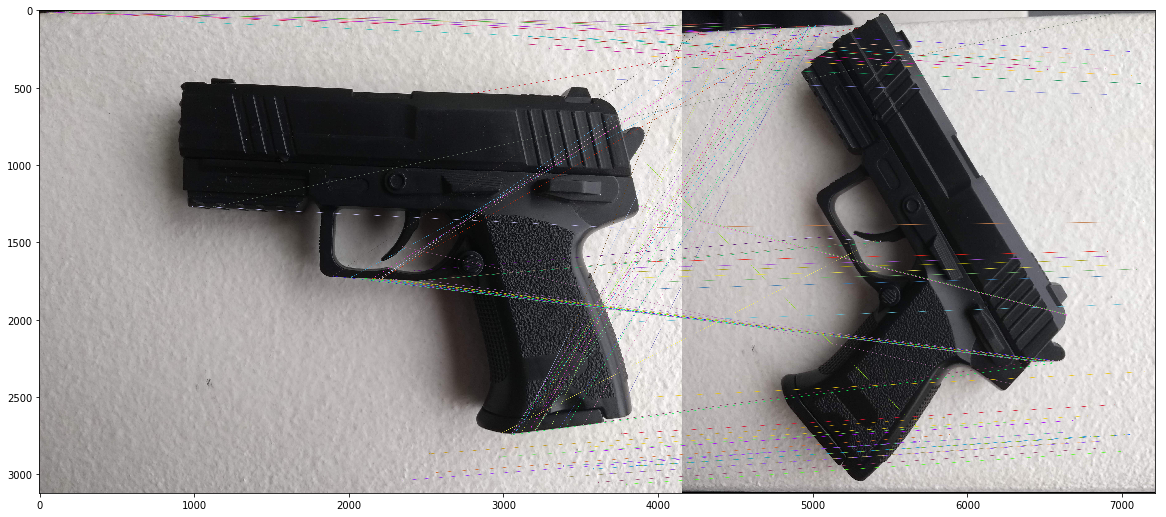

In [17]:

def BFMatcher(image_1, image_2, threshold=300):
    surf = cv2.xfeatures2d.SURF_create(threshold)
    surf.setUpright(True)

    kp_train_1, des_train_1 = surf.detectAndCompute(image_1, None)
    kp_train_2, des_train_2 = surf.detectAndCompute(image_2, None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des_train_1, des_train_2)
    # print(matches.distance)
    # Sort them in the order of their distance.
    matches = sorted(matches, key=lambda x: x.distance)
    # Draw first 10 matches.
    img3 = cv2.drawMatches(image_1, kp_train_1, image_2, kp_train_2, matches[:100], flags=2, outImg=None)
    plt.figure(figsize=(20,10))
    plt.imshow(img3)
    plt.show()

BFMatcher(ref, ref, 300)
BFMatcher(ref, miroir, 300)
BFMatcher(ref, occlusion, 300)
BFMatcher(ref, rotation, 100)
    

## FlannMatcher

En deuxième nous avons utilisé Flann, qui est un algorithme de knn optimisé pour les hautes dimensions, ce qui est pertinent pour comparer les descriptions des points particuliers.

Cependant les résultats sont beaucoup moins bons que pour BFMatcher.

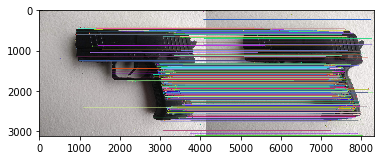

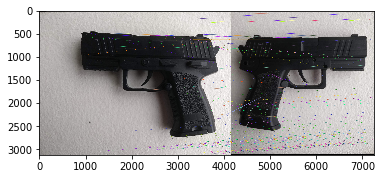

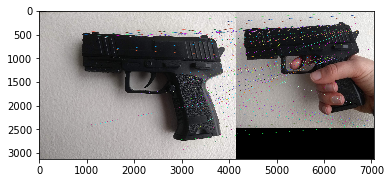

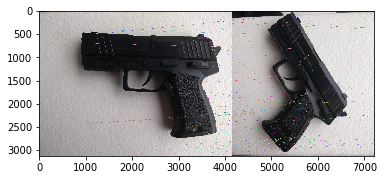

In [6]:

def flannMatcher(img1, img2, minHessian) :
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    detector = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    keypoints1, descriptors1 = detector.detectAndCompute(img1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(img2, None)
    #-- Step 2: Matching descriptor vectors with a FLANN based matcher
    # Since SURF is a floating-point descriptor NORM_L2 is used
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)
    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    #-- Draw matches
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
    cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #-- Show detected matches
    plt.imshow(img_matches)
    plt.show()
    
flannMatcher(ref,ref, 500)
flannMatcher(ref, miroir, 500)
flannMatcher(ref, occlusion, 500)
flannMatcher(ref, rotation, 500)

## Utilisation pour de la détection
Nous voulions savoir si nous pouvions utiliser ces algorithme pour détecter une arme sur une image de manière efficace.

L'avantage de ces techniques est qu'elles ne requièrent aucun entraînement ni de grands volumes de données. Une seule image de référence suffit. Cependant nous ne pouvons pas faire de détection automatique avec ces techniques, car elles ne sont pas assez précises au niveau de leurs correspondances.